In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('./owid-covid-data.xlsx')

In [10]:
japan = df[df['iso_code']=='JPN']
japan = japan.fillna(0)

date = pd.DataFrame({'일자' : japan['date']})
location = pd.DataFrame({'location' : japan['location']})

japan.drop(['iso_code','continent','location','date'], axis=1,inplace=True)

In [11]:
X = japan[['total_cases',
 'icu_patients',
 'total_vaccinations',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate',
'new_tests',
'total_tests']]
y = japan['new_deaths']

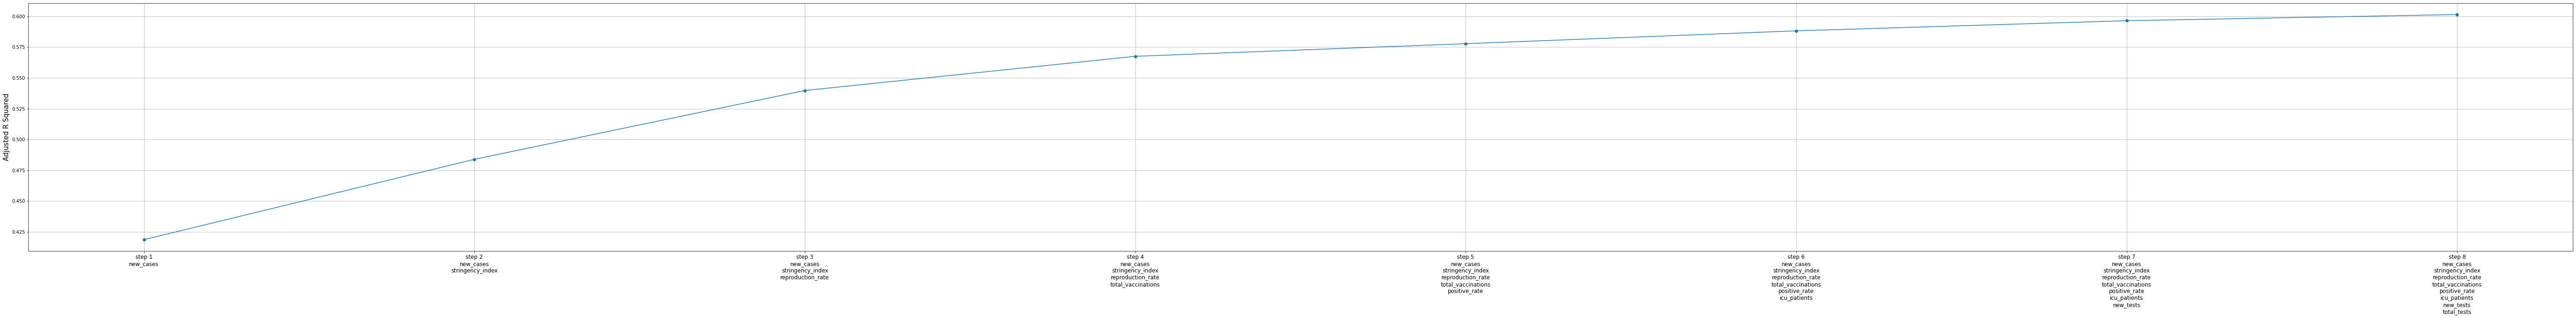

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [13]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     127.2
Date:                Wed, 11 May 2022   Prob (F-statistic):          2.26e-128
Time:                        20:15:50   Log-Likelihood:                -3211.4
No. Observations:                 670   AIC:                             6441.
Df Residuals:                     661   BIC:                             6481.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -18.5615      5

In [14]:
X = japan[selected_variables]
X

,new_cases,stringency_index,reproduction_rate,total_vaccinations,positive_rate,icu_patients,new_tests,total_tests
84669,0.0,2.78,0.00,0.0,0.000,0.0,0.0,0.0
84670,0.0,2.78,0.00,0.0,0.000,0.0,0.0,0.0
84671,0.0,2.78,0.00,0.0,0.000,0.0,0.0,0.0
84672,0.0,2.78,0.00,0.0,0.000,0.0,0.0,0.0
84673,2.0,2.78,0.00,0.0,0.000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
85502,26414.0,0.00,0.65,0.0,0.347,0.0,92663.0,47095704.0
85503,20712.0,0.00,0.58,272738717.0,0.000,0.0,0.0,0.0
85504,21541.0,0.00,0.00,0.0,0.000,0.0,0.0,0.0
85505,39228.0,0.00,0.00,0.0,0.000,0.0,0.0,0.0


In [15]:
lm = sm.OLS(y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             new_deaths   R-squared (uncentered):                   0.751
Model:                            OLS   Adj. R-squared (uncentered):              0.749
Method:                 Least Squares   F-statistic:                              313.7
Date:                Wed, 11 May 2022   Prob (F-statistic):                   6.54e-245
Time:                        20:15:51   Log-Likelihood:                         -4024.7
No. Observations:                 838   AIC:                                      8065.
Df Residuals:                     830   BIC:                                      8103.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
new_cases              0.0009      0.000      6.908      0.000       0.001       0.001
stringency_index       1.1445      0.069     16.558      0.000       1.009       1.280
reproduction_rate    -28.4187      2.059    -13.803      0.000     -32.460     -24.378
total_vaccinations -1.097e-07   1.74e-08     -6.311      0.000   -1.44e-07   -7.56e-08
positive_rate        122.0313     21.224      5.750      0.000      80.371     163.691
icu_patients           0.0122      0.003      4.451      0.000       0.007       0.018
new_tests              0.0001   2.02e-05      5.030      0.000    6.21e-05       0.000
total_tests        -3.503e-07   1.38e-07     -2.547      0.011    -6.2e-07   -8.04e-08
==============================================================================
Omnibus:                      238.408   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1137.643
Skew:                           1.225   Prob(JB):                    9.20e-248
Kurtosis:                       8.156   Cond. No.                     1.91e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.91e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
p = lm.predict(X).round(0)
p_dead = pd.DataFrame({'추정사망(명)':p})
p_dead[p_dead['추정사망(명)']<=0] = 0
dead = pd.DataFrame({'사망(명)':y})

japan_COVID = pd.concat([date,location,X,dead,p_dead], axis=1)
japan_COVID.reset_index(inplace=True)
japan_COVID.drop(['index'],axis=1,inplace=True)

japan_COVID.to_excel('./일본.xlsx')